In [2]:
using Interpolations
#using Dierckx
using NPZ
#using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics
using PyCall
using FFTW

In [3]:
A = npzread("/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_new/dt.scratch/b_hat_rho_mpi_nm.npy");

In [27]:
size(A)

(101, 65, 33, 204)

In [4]:
rdim = size(A)[1];
ufdim = size(A)[2];
fidim = size(A)[3];
tdim = size(A)[4];

In [5]:
time_list = LinRange(1,tdim,tdim);
psin_list = LinRange(0,1.0,rdim);
uf_list = LinRange(0,2*pi,ufdim);
fi_list = LinRange(0,2*pi,fidim);

## Safety factor term for island width

The (m,n) island width is given by the term $\delta_{mn}= \sqrt{\frac{|4 b_{mn}|}{|m \frac{d\iota}{d\psi_t}|}}$, where $\frac{d\iota}{d\psi_t} = -\frac{1}{q^3} \frac{dq}{d\psi_p}$.

In [6]:
q = npzread("/net/scratch3/giannis_kx/pixie3d/iter/iter3d/db_new/dt.scratch/q_mpi_nm.npy");

In [7]:
function q_prime(q,dpsi)
    L = length(q);
    qp = circshift(q,1);
    qm = circshift(q,-1);
    qprime = (qp-qm)/(2*dpsi);
    qprime[1] = (q[2]-q[1])/dpsi;
    qprime[end] = (q[end]-q[end-1])/dpsi
    return qprime
end

q_prime (generic function with 1 method)

In [8]:
qPrime = q_prime(q[:,109],1/100);

In [9]:
factor = -1 ./(q[:,109].^3).*qPrime;

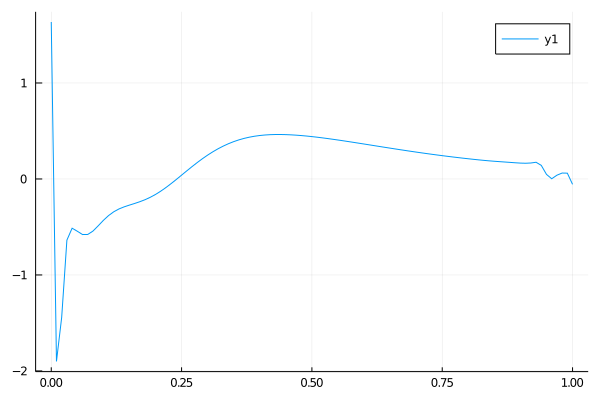

In [880]:
Plots.plot()
#Plots.plot!(psin_list,q[:,109],legend=false)
#Plots.plot!(psin_list,qPrime)
Plots.plot!(psin_list,factor)

## Truncation

In [10]:
bpert = A[:,:,:,110];

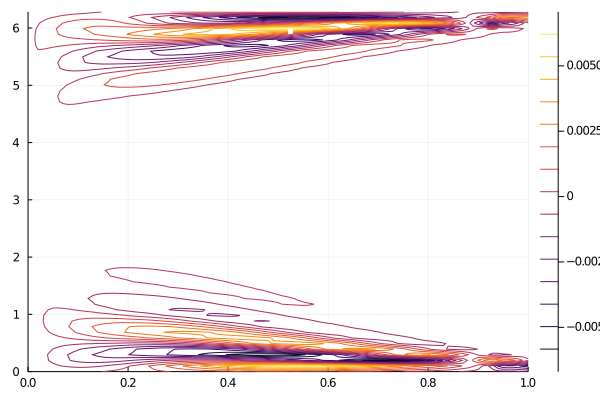

In [11]:
Plots.contour(psin_list,uf_list,bpert[:,:,1]',colorbar=:true)#,right_margin=10Plots.mm)

In [12]:
bhat = fft(bpert,[2,3]);

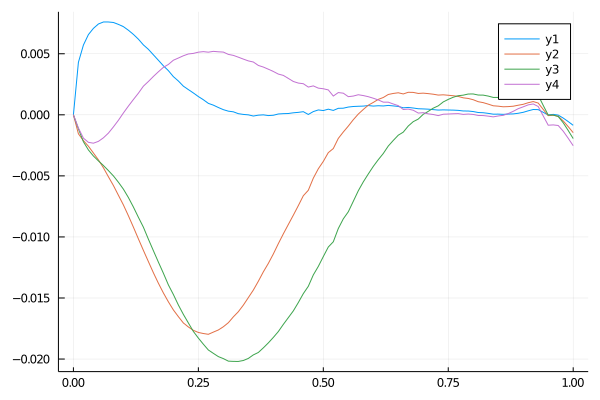

In [884]:
# make sure the fft works as intended
Plots.plot(psin_list,imag(bhat[:,end,2]))
Plots.plot!(psin_list,imag(bhat[:,end-1,2]))
Plots.plot!(psin_list,imag(bhat[:,end-2,2]))
Plots.plot!(psin_list,imag(bhat[:,end-2,3]))

## Plotting mode numbers

In [13]:
B = A[:,:,:,109];

In [14]:
C = fft(B,[2,3]);

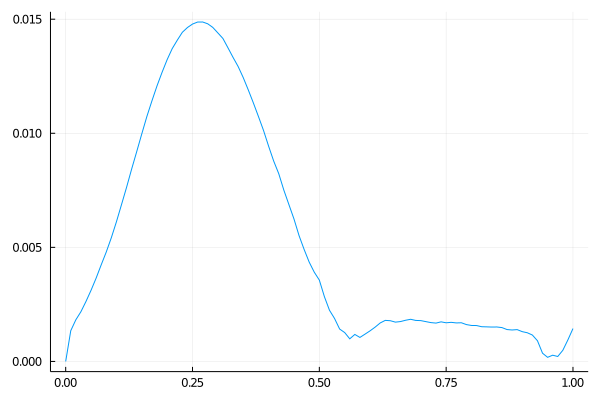

In [15]:
Plots.plot(psin_list,abs.(C[:,end-1,2]),label=false)

Frequencies are placed at the same places as numpy. For reference:
f = [0,1,...,n/2-1,-n/2,...,-1], when n is even. 
ind = [1,2,...,n/2, end-(n/2 -1),-1], i.e., -n mode is at [end - (n-1)].
f = [0,1,...,(n-1)/2,-(n-1)/2,...,-1], when n is odd.
ind = [1,2,...,(n-1)/2+1,n-((n-1)/2 -1),...,-1], i.e., -n mode is at [end - (n-1)]

In [16]:
include("fftUtils.jl")
using .fftUtils

## Finding mode maxima

In [17]:
maxbnm = [];
isl_width = [];
ms = [];
misl = [];
nisl = [];
ns = [];
Nm = size(C)[2];
Nn = size(C)[3];
for m in 1:size(C)[2]
    for n in 1:size(C)[3]
        max, maxInd = findmax(abs.(C[:,m,n]))
        append!(maxbnm,max)
        #q_factor = (-1 ./q[maxInd,109].^3) .*qPrime[maxInd]
        #if m == 1
        #    append!(ms,0)
        #end
        #if m <= ((Nm-1)/2)+1 && m > 1
        #    append!(ms, -(m-1)) # m's have flipped frequencies
        #    append!(misl, -(m-1))
        #    wmn = sqrt((4*max)/abs(-(m-1)*q_factor))
        #    append!(isl_width,wmn)
        #end
        #if m > ((Nm-1)/2)+1
        #    append!(ms,Nm-m+1)
        #    append!(misl,Nm-m+1)
        #    wmn = sqrt((4*max)/abs((Nm-m+1)*q_factor))
        #    append!(isl_width,wmn)
        #end
        #if n == 1
        #    append!(ns,0)
        #    if m != 1
        #        append!(nisl,0)
        #    end
        #end
        #if n <= ((Nn-1)/2)+1 && n > 1
        #    append!(ns, n-1)
        #    if m != 1 
        #        append!(nisl, n-1)
        #    end
        #end
        #if n > ((Nn-1)/2)+1 
        #    append!(ns,n-(Nn+1))
        #    if m!= 1
        #        append!(nisl, n-(Nn+1))
        #    end
        #end
        append!(ns,n_mode_num(n,Nn))
        append!(ms,m_mode_num(m,Nm))
        #if m !=1
        #    append!(nisl,n_mode_num(n))
        #    append!(misl,m_mode_num(m))
        #    wmn = sqrt((4*max)/abs(m_mode_num(m)*q_factor))
        #    append!(isl_width,wmn)
        #end
    end
end

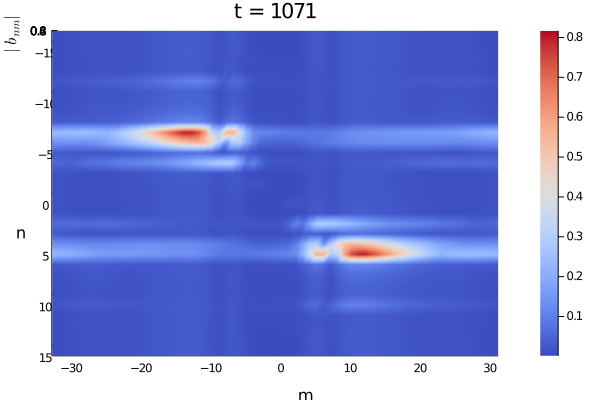

In [19]:
Plots.scatter(ns,ms,maxbnm,zlabel=L"|b_{nm}|",camera=(90,90),st=:surface,c=:coolwarm)
xlabel!("n")
ylabel!("m")
title!("t = 1071")

In [26]:
n_mode_num(18,Nn)

-16

## Size of islands

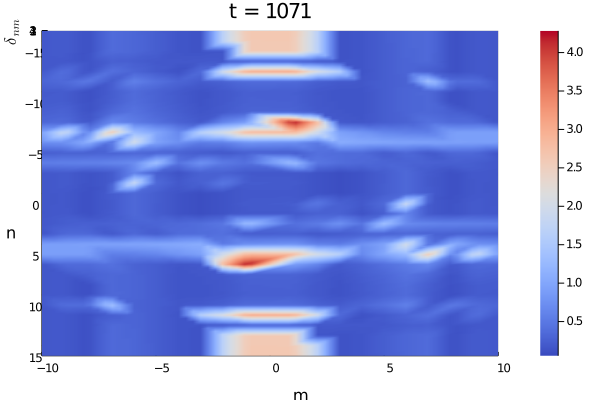

In [911]:
Plots.scatter(nisl,misl,isl_width,zlabel=L"\delta_{nm}",camera=(90,90),st=:surface,c=:coolwarm,ylims=(-10,10))
xlabel!("n")
ylabel!("m")
title!("t = 1071")

## Sorting largest coefficients

In [749]:
coeffs = []
for m in 1:Nm
    for n in 1:Nn
        max = maximum(abs.(imag(C[:,m,n])))
        append!(coeffs,max)
    end
end

In [750]:
scoeffs = sortperm(coeffs,rev=true);

In [751]:
nvec = []
mvec = []
for i in 1:length(scoeffs)
    m = div(scoeffs[i],Nn)
    if m == Nm
        append!(mvec,m)
    else
        append!(mvec,m+1)
    end
    n = mod(scoeffs[i],Nn)
    if n == 0
        append!(nvec,Nn)
    else
        append!(nvec,n)
    end
end

## mode index to mode number

In [857]:
function n_mode_num(n)
    if n == 1
        mode = 0
    end
    if n <= ((Nn-1)/2)+1 && n > 1
        mode =  n-1
    end
    if n > ((Nn-1)/2)+1
        mode = n-(Nn+1)
    end
    return mode
end

n_mode_num (generic function with 1 method)

In [866]:
function m_mode_num(m)
    if m == 1
        mode = 0
    end
    if m <= ((Nm-1)/2)+1 && m > 1
        mode = -(m-1) # m's have flipped frequencies
    end
    if m > ((Nm-1)/2)+1
        mode = Nm-m+1
    end
    return mode
end

m_mode_num (generic function with 1 method)

## mode number to mode index

In [754]:
function m_mode_ind(m)
    if m == 0
        ind = 1
    end
    if m < 0 
        ind = abs(m)+1
    end
    if m > 0
        ind = Nm - m +1
    end
    return ind
end

m_mode_ind (generic function with 1 method)

In [755]:
function n_mode_ind(n)
    if n == 0
        ind = 1
    end
    if n > 0
        ind = n+1
    end
    if n < 0
        ind = Nn - (abs(n)-1)
    end
    return ind
end

n_mode_ind (generic function with 1 method)

In [908]:
m_mode_num(65)

1

In [855]:
Nn

33

## Spatial variation of largest modes

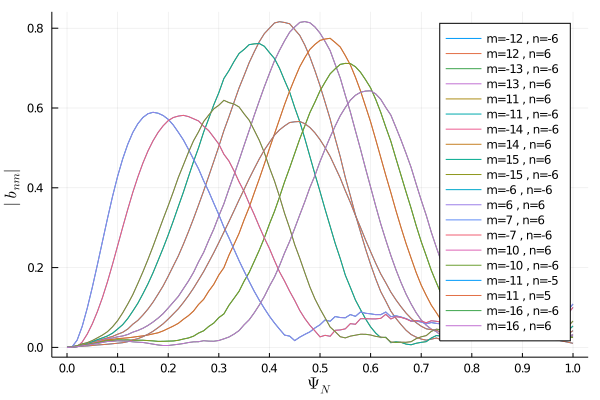

In [756]:
Plots.plot();
for i in 1:20
    m_ind = mvec[i]
    n_ind = nvec[i]
    m = m_mode_num(m_ind)
    n = n_mode_num(n_ind)
    qval = round(m/n; digits=2)
    Plots.plot!(psin_list,abs.(C[:,m_ind,n_ind]),ylabel=(L"|b_{nm}|"),labels=("m=$(m) , n=$(n)"))
    #Plots.plot!(psin_list,abs.(C[:,m,n]),ylabel=(L"|b_{nm}|"),labels=("q =$qval"),legend=:topright)
    xticks!([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
end
#Plots.plot!(Plots.twinx()/100,q[:,109],legend=false,ylabel=("Q"))
xlabel!(L"\Psi_N")
current()

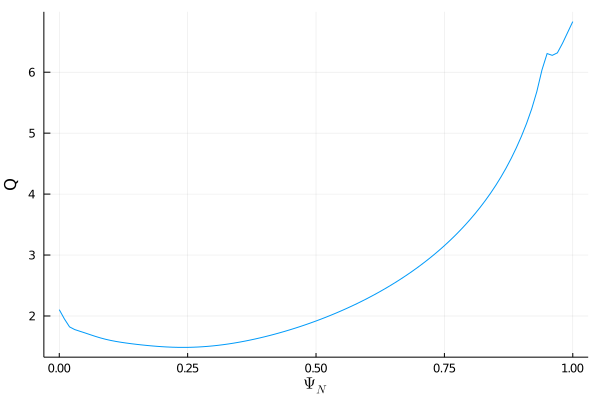

In [649]:
Plots.plot(psin_list,q[:,109],legend=false,ylabel=("Q"))
xlabel!(L"\Psi_N")

## Truncation by throwing out smallest modes

In [698]:
SC = deepcopy(C);

In [699]:
Nthrow = 2000;
for i in 0:(Nthrow-1)
    SC[:,mvec[end-i],nvec[end-i]] .= 0;
end

In [700]:
Smaxbnm = [];
Sms = [];
Sns = [];
SNm = size(SC)[2];
SNn = size(SC)[3];
for m in 1:size(SC)[2]
    for n in 1:size(SC)[3]
        max = maximum(abs.(imag(SC[:,m,n])))
        append!(Smaxbnm,max)
        if m == 1
            append!(Sms,0)
        end
        if m <= (Nm-1)/2 && m > 1
            append!(Sms, m-(Nm+1)) # m's have flipped frequencies
        end
        if m > (Nm-1)/2
            append!(Sms,m-1)
        end
        if n == 1
            append!(Sns,0)
        end
        if n <= (Nn-1)/2 && n > 1
            append!(Sns, n-1)
        end
        if n > (Nn-1)/2
            append!(Sns,n-(Nn+1))
        end
    end
end

In [701]:
Plots.plot();

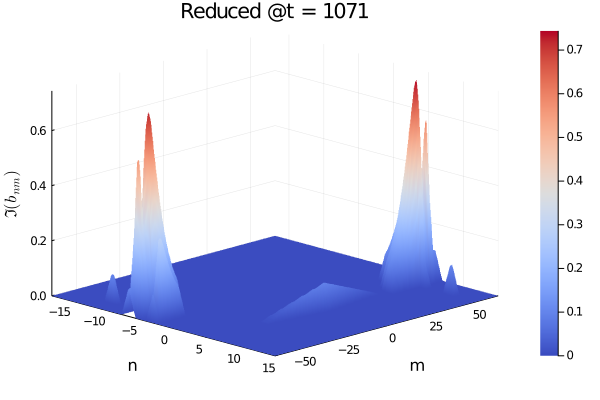

In [702]:
Plots.scatter!(Sns,Sms,Smaxbnm,zlabel=L"\Im(b_{nm})",camera=(45,45),st=:surface,c=:coolwarm)
xlabel!("n")
ylabel!("m")
title!("Reduced @t = 1071")

## Sorting modes (deprecated)

In [73]:
size(bhat)

(101, 65, 33)

In [109]:
mvec = [];
for m in 1:size(bhat)[2]
    m_mode = mean(bhat[:,m,:])
    append!(mvec,abs(imag(m_mode)))
end

In [110]:
N_to_discard = 5;
smvec = sortperm(mvec,rev=true);
keep_ind = smvec[1:end-N_to_discard];
disc_ind = smvec[end-N_to_discard+1:end];

In [111]:
bhatz = deepcopy(bhat);

In [112]:
bhatz[:,disc_ind,:] .= 0;

In [117]:
bhatz[6,1,22]

0.0 + 0.0im

In [118]:
bhat[:,disc_ind,:] .= 0;

In [119]:
bhat_inv = ifft(bhat,[2,3]);

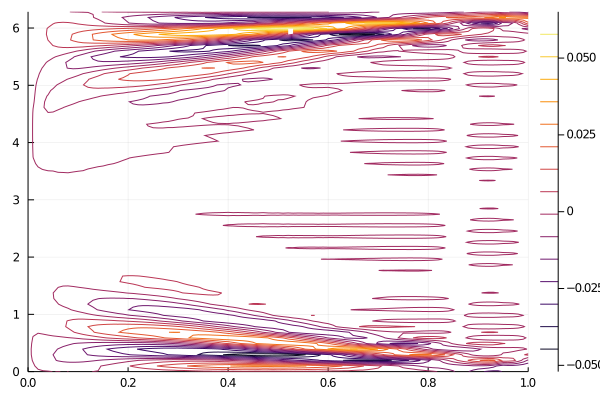

In [120]:
# make sure inverse fft works as intended
Plots.contour(psin_list,uf_list,real(bhat_inv[:,:,1])',colorbar=:true)

In [36]:
# Shift the frequencies so you can throw away the edges
bhat_shift = fftshift(bhat,[2,3]);

In [57]:
# Truncate the fft by throwing out high frequencies
bhat_trunc = bhat_shift[:,6:end-5,4:end-3];

In [58]:
# Shift the frequencies back so inverse works
bhat_trunc_ishift = ifftshift(bhat_trunc,[2,3]);

In [59]:
# Invert truncated fft
bpert_trunc = ifft(bhat_trunc_ishift,[2,3]);

In [60]:
# Reduced dimensionality
uf_r = LinRange(0,2*pi,size(bpert_trunc)[2]);

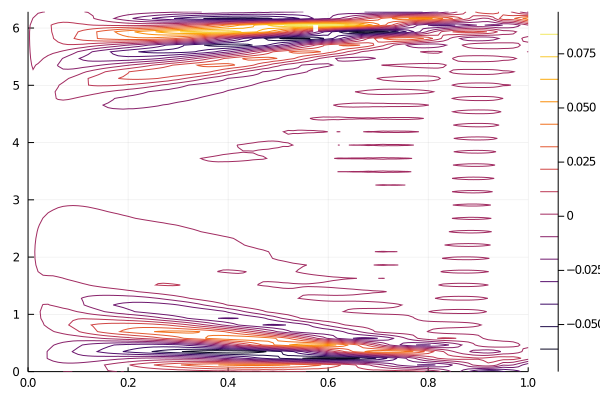

In [61]:
Plots.contour(psin_list,uf_r,real(bpert_trunc[:,:,1])',colorbar=:true)

## spatial variation of modes animation

In [13]:
gr()

Plots.GRBackend()

In [15]:
anim = Plots.Animation()
for t in 1:tdim
    Plots.plot(psin_list,imag(bnmt[:,2,2,t]),xlims=(0,1),ylims=(-0.4,0.4),color="red",labels=("m=1,n=1"),legend=:bottomright)
    Plots.plot!(psin_list,imag(bnmt[:,2,4,t]),xlims=(0,1),ylims=(-0.4,0.4),color="blue",labels=("m=2,n=1"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-2,2,t]),xlims=(0,1),ylims=(-6.8,6.8),color="green",labels=("m=3,n=1"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-2,3,t]),xlims=(0,1),ylims=(-6.8,6.8),color="black",labels=("m=3,n=2"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-4,4,t]),xlims=(0,1),ylims=(-6.8,6.8),color="blue",labels=("m=5,n=3"))
    #Plots.plot!(psin_list,c*imag(bnmt[:,end-7,5,t]),xlims=(0,1),ylims=(-6.8,6.8),color="magenta",labels=("m=8,n=5"))
    xlabel!(L"$\Psi_n$")
    ylabel!(L"$\textrm{Im}(\hat{b}^{\rho}_{m/n})$")
    time=t
    annotate!((0.9,0.3,"t="*string(time)))
    Plots.frame(anim)
end

┌ Info: Saved animation to 
│   fn = /turquoise/users/giannis_kx/Julia/tmp.gif
└ @ Plots /users/giannis_kx/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/turquoise/users/giannis_kx/Julia/tmp.gif")
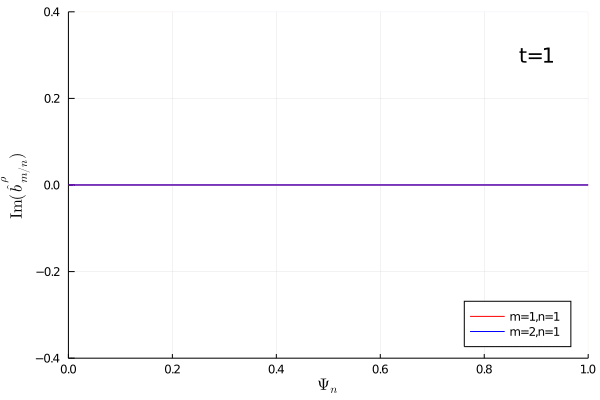

In [16]:
gif(anim,fps=30)

## mode maxima animation

In [414]:
anim2 = Plots.Animation()
Plots.plot();
for t in 1:tdim
    B = A[:,:,:,t];
    C = fft(B,[2,3]);
    maxbnm = [];
    ms = [];
    ns = [];
    Nm = size(C)[2];
    Nn = size(C)[3];
    for m in 1:size(C)[2]
        for n in 1:size(C)[3]
            max = maximum(abs.(C[:,m,n]))
            append!(maxbnm,max)
            if m == 1
                append!(ms,0)
            end
            if m <= (Nm-1)/2 && m > 1
                append!(ms, m-(Nm+1)) # m's have flipped frequencies
            end
            if m > (Nm-1)/2
                append!(ms,m-1)
            end
            if n == 1
                append!(ns,0)
            end
            if n <= (Nn-1)/2 && n > 1
                append!(ns, n-1)
            end
            if n > (Nn-1)/2
                append!(ns,n-(Nn+1))
            end
        end
    end
    Plots.scatter!(ns,ms,maxbnm,zlabel=L"|b_{nm}|", zlims=(0,10), camera=(45,45),st=:surface,c=:coolwarm,clims=(0,10))
    xlabel!("n")
    ylabel!("m")
    time=t
    title!("t = "*string(time))
    Plots.frame(anim2)
end

┌ Info: Saved animation to 
│   fn = /turquoise/users/giannis_kx/Julia/tmp.gif
└ @ Plots /users/giannis_kx/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/turquoise/users/giannis_kx/Julia/tmp.gif")
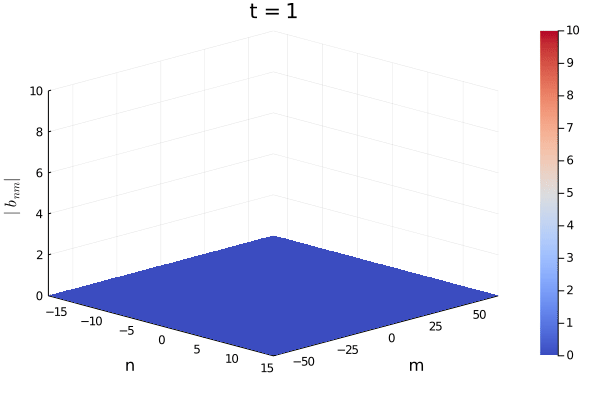

In [415]:
gif(anim2,fps=30)

## Finding the $\hat{b}^{\theta_f}$ perturbation by using the formula $\hat{b}^{\theta_f}_{mn} = -\frac{i}{m}\frac{\partial \hat{b}^{\psi}_{mn}}{\partial \psi}$.

In [808]:
m_index_list = LinRange(1,size(bhat)[2],size(bhat)[2]);
n_index_list = LinRange(1,size(bhat)[3],size(bhat)[3]);

In [806]:
m_mode_list = []
for m in m_index_list
    mode = m_mode_num(m)
    append!(m_mode_list,convert(Int64,mode))
end

In [809]:
n_mode_list = []
for n in n_index_list
    mode = n_mode_num(n)
    append!(n_mode_list,convert(Int64,mode))
end

Splining the Fourier coeeficients

In [810]:
bpsi = deepcopy(bhat);

In [812]:
bpsi_int = Interpolations.interpolate(bpsi,(BSpline(Cubic(Line(OnGrid()))), BSpline(Cubic(Periodic(OnGrid()))), BSpline(Cubic(Periodic(OnGrid())))));

In [813]:
bpsi_sint = scale(bpsi_int,psin_list,m_index_list,n_index_list);

In [814]:
bpsi_eint = extrapolate(bpsi_sint,(Line(),Periodic(),Periodic()));

In [815]:
1im*Interpolations.gradient(bpsi_eint,0.1,-1,0.0)[1]

-0.02637621260515059 - 0.0007373359600867989im

In [830]:
b_uf_mn = []
mock_var = []
for p in psin_list
    for m in m_index_list
        for n in n_index_list
            append!(mock_var,1)
            if m !=1
                mode = m_mode_num(m)
                b = (-1im/mode)*Interpolations.gradient(bpsi_eint,p,m,n)[1]
                append!(b_uf_mn,b)
            else
                append!(b_uf_mn,0)
            end
        end
    end
end
b_uf_mn = permutedims(reshape(b_uf_mn,length(n_index_list),length(m_index_list),length(psin_list)),(3,2,1));            

In [831]:
size(b_uf_mn)

(101, 65, 33)

In [832]:
b_uf_mn[19,3,3]

0.0012434275951109931 - 0.0012076993995633846im

In [833]:
LL = deepcopy(b_uf_mn);

In [836]:
LLF = Complex{Float64}.(LL);

In [837]:
LLF[19,3,3]

0.0012434275951109931 - 0.0012076993995633846im

In [838]:
iLL = ifft(LLF,[2,3])

101×65×33 Array{Complex{Float64},3}:
[:, :, 1] =
  -0.00443455-4.96519e-7im   …    -0.0049518+5.01549e-7im
  -0.00371775-4.87123e-7im       -0.00405775+4.84861e-7im
  -0.00284754-1.90276e-6im        -0.0032532+1.90097e-6im
  -0.00329555-2.52365e-6im       -0.00374896+2.52586e-6im
  -0.00321338-6.79988e-7im        -0.0032358+6.79156e-7im
  -0.00276858-6.63581e-7im   …   -0.00268399+6.62449e-7im
  -0.00312167-2.068e-6im         -0.00315548+2.06782e-6im
  -0.00274668-1.62425e-6im       -0.00260004+1.62491e-6im
  -0.00232891-1.53458e-6im       -0.00203626+1.53465e-6im
  -0.00207173-1.79085e-6im       -0.00184923+1.78808e-6im
  -0.00170363-2.19839e-6im   …    -0.0014778+2.19664e-6im
  -0.00125205+1.00177e-7im      -0.000795266-1.01915e-7im
 -0.000899989+1.99349e-6im      -0.000250514-1.9921e-6im
             ⋮               ⋱  
  0.000530893-0.000382124im     -0.000458908+0.000382357im
  0.000123245-0.000364193im  …  -0.000711524+0.000364278im
 -0.000354842-0.000334798im     -0.000774277+0.